In [0]:
!pip install git+https://github.com/tensortrade-org/tensortrade.git

<a href="https://colab.research.google.com/github/kodiakcrypto/tensortrade/blob/master/examples/Intro_TensorTrade_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def fetch_candles(exchange_name, symbol, timeframe, add_TA=False):
    url = "https://www.cryptodatadownload.com/cdd/"
    filename = "{}_{}USD_{}.csv".format(exchange_name, symbol, timeframe)
    
    df = pd.read_csv(url + filename, skiprows=1)
    df = df[::-1] # Flip list order
    df = df.drop(["Symbol"], axis=1)
    df = df.rename(columns = {'Volume USD': 'Volume'})
    df = df.set_index("Date")

    if add_TA:
        !pip install ta
        import ta

        ta.add_all_ta_features(
            df, "Open", "High", "Low", "Close", "Volume", fillna=True
        )

    df.columns = [symbol + ":" + name.lower() for name in df.columns]
                     
    return df

In [3]:
data = fetch_candles("Coinbase", "BTC", "d", add_TA=True) # 1h also available

data

  Created wheel for ta: filename=ta-0.5.20-cp36-none-any.whl size=24033 sha256=21291b861b5c175a6b6c94f136dea09c6165584ba1802974b6b5197da28e0bd5
  Stored in directory: /root/.cache/pip/wheels/8a/22/4a/8c797d97dfc07b92bbe9294969ce1d55c1d4bf16e1cc2c1320
Successfully built ta


/usr/local/lib/python3.6/dist-packages/ta/trend.py:567: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:571: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


,BTC:open,BTC:high,BTC:low,BTC:close,BTC:volume btc,BTC:volume,BTC:volume_adi,BTC:volume_obv,BTC:volume_cmf,BTC:volume_fi,BTC:momentum_mfi,BTC:volume_em,BTC:volume_sma_em,BTC:volume_vpt,BTC:volume_nvi,BTC:volume_vwap,BTC:volatility_atr,BTC:volatility_bbm,BTC:volatility_bbh,BTC:volatility_bbl,BTC:volatility_bbw,BTC:volatility_bbp,BTC:volatility_bbhi,BTC:volatility_bbli,BTC:volatility_kcc,BTC:volatility_kch,BTC:volatility_kcl,BTC:volatility_kcw,BTC:volatility_kcp,BTC:volatility_kchi,BTC:volatility_kcli,BTC:volatility_dcl,BTC:volatility_dch,BTC:volatility_dchi,BTC:volatility_dcli,BTC:trend_macd,BTC:trend_macd_signal,BTC:trend_macd_diff,BTC:trend_sma_fast,BTC:trend_sma_slow,BTC:trend_ema_fast,BTC:trend_ema_slow,BTC:trend_adx,BTC:trend_adx_pos,BTC:trend_adx_neg,BTC:trend_vortex_ind_pos,BTC:trend_vortex_ind_neg,BTC:trend_vortex_ind_diff,BTC:trend_trix,BTC:trend_mass_index,BTC:trend_cci,BTC:trend_dpo,BTC:trend_kst,BTC:trend_kst_sig,BTC:trend_kst_diff,BTC:trend_ichimoku_a,BTC:trend_ichimoku_b,BTC:trend_visual_ichimoku_a,BTC:trend_visual_ichimoku_b,BTC:trend_aroon_up,BTC:trend_aroon_down,BTC:trend_aroon_ind,BTC:trend_psar,BTC:trend_psar_up,BTC:trend_psar_down,BTC:trend_psar_up_indicator,BTC:trend_psar_down_indicator,BTC:momentum_rsi,BTC:momentum_tsi,BTC:momentum_uo,BTC:momentum_stoch,BTC:momentum_stoch_signal,BTC:momentum_wr,BTC:momentum_ao,BTC:momentum_kama,BTC:momentum_roc,BTC:others_dr,BTC:others_dlr,BTC:others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-01,300.00,370.00,300.00,370.00,0.05656,1.953000e+01,1.953000e+01,1.953000e+01,1.000000,0.000000e+00,50.000000,0.000000e+00,0.000000e+00,1.878163e+05,1000.000000,346.666667,0.000000,370.000000,370.000000,370.000000,0.000000,0.000000,0.0,0.0,346.666667,416.666667,276.666667,40.384615,0.666667,0.0,0.0,370.00,370.00,1.0,1.0,0.000000,0.000000,0.000000,370.000000,370.000000,370.000000,370.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-90.905190,1.000000,0.000000,3774.814652,-910.731835,-910.731835,0.000000,335.000,335.000,4098.689596,4109.92599,4.0,4.0,0.0,370.000000,-1.000000,-1.00,0.0,0.0,100.000000,0.000000,50.000000,100.000000,100.000000,-0.000000,0.000000,370.000000,0.000000,-91.073183,0.000000,0.000000
2014-12-02,370.00,378.00,370.00,378.00,15.01000,5.675070e+03,5.694600e+03,5.694600e+03,1.000000,4.540056e+04,50.000000,5.497730e+06,5.497730e+06,1.049176e+02,1000.000000,375.235019,0.000000,374.000000,382.000000,366.000000,4.278075,0.750000,0.0,0.0,361.000000,400.000000,322.000000,21.606648,0.717949,0.0,0.0,370.00,378.00,1.0,0.0,0.638177,0.127635,0.510541,374.000000,374.000000,371.230769,370.592593,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.004223,1.853081,66.666667,3770.814652,-909.766773,-910.249304,0.482531,339.000,339.000,4098.689596,4109.92599,8.0,4.0,4.0,378.000000,-1.000000,-1.00,0.0,0.0,100.000000,100.000000,50.000000,100.000000,100.000000,-0.000000,0.000000,378.000000,0.000000,2.162162,2.139119,2.162162
2014-12-03,378.00,378.00,377.01,378.00,0.54660,2.065200e+02,5.901120e+03,5.901120e+03,1.000000,3.891477e+04,50.000000,1.680200e+06,3.588965e+06,1.227042e+02,1000.000000,375.320236,0.000000,375.333333,382.875806,367.790861,4.019079,0.676777,0.0,0.0,366.556667,392.886667,340.226667,14.366128,0.717306,0.0,0.0,370.00,378.00,1.0,0.0,1.130900,0.328288,0.802612,375.333333,375.333333,372.272189,371.141289,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.011085,2.584499,55.873974,3769.481319,-909.445086,-909.981231,0.536145,339.000,339.000,4098.689596,4109.92599,8.0,4.0,4.0,370.000000,-1.000000,370.00,0.0,1.0,100.000000,100.000000,50.000000,100.000000,100.000000,-0.000000,0.000000,378.000000,0.000000,0.000000,0.000000,2.162162
2014-12-04,378.00,378.00,377.10,377.10,0.01000,3.770000e+00,5.897350e+03,5.897350e+03,0.998723,3.335503e+04,50.000000,1.074271e+06,2.750734e+06,-8.976190e-03,997.619048,375.321563,0.000000,375.775000,382.483763,369.066237,3.570628,0.598751,0.0,0.0,369.267500,389.240000,349.29500

#Setup Trading Environment

### Create a 'DataFeed' for the Gym TradingEnvironment to be able to observe and make actions about
- Make a list of Stream objects, one for each DataFrame column

In [0]:
from tensortrade.data import Module, Stream

with Module("coinbase") as node_stream:
    nodes = []
    for name in data.columns:
        nodes.append(
            Stream(list(data[name]), name)
        )

In [0]:
from tensortrade.data import DataFeed

data_feed = DataFeed([node_stream])

In [16]:
data_feed.next() # Show 1 slice of the data

{'coinbase:/BTC:close': 370.0,
 'coinbase:/BTC:high': 370.0,
 'coinbase:/BTC:low': 300.0,
 'coinbase:/BTC:momentum_ao': 0.0,
 'coinbase:/BTC:momentum_kama': 370.0,
 'coinbase:/BTC:momentum_mfi': 50.0,
 'coinbase:/BTC:momentum_roc': 0.0,
 'coinbase:/BTC:momentum_rsi': 100.0,
 'coinbase:/BTC:momentum_stoch': 100.0,
 'coinbase:/BTC:momentum_stoch_signal': 100.0,
 'coinbase:/BTC:momentum_tsi': 0.0,
 'coinbase:/BTC:momentum_uo': 50.0,
 'coinbase:/BTC:momentum_wr': -0.0,
 'coinbase:/BTC:open': 300.0,
 'coinbase:/BTC:others_cr': 0.0,
 'coinbase:/BTC:others_dlr': 0.0,
 'coinbase:/BTC:others_dr': -91.07318345799003,
 'coinbase:/BTC:trend_adx': 0.0,
 'coinbase:/BTC:trend_adx_neg': 0.0,
 'coinbase:/BTC:trend_adx_pos': 0.0,
 'coinbase:/BTC:trend_aroon_down': 4.0,
 'coinbase:/BTC:trend_aroon_ind': 0.0,
 'coinbase:/BTC:trend_aroon_up': 4.0,
 'coinbase:/BTC:trend_cci': 0.0,
 'coinbase:/BTC:trend_dpo': 3774.8146521076624,
 'coinbase:/BTC:trend_ema_fast': 370.0,
 'coinbase:/BTC:trend_ema_slow': 370.0,


###Define Exchange
An exchange needs a name, an execution service, and streams of price data in order to function properly.

The setups supported right now are the simulated execution service using simulated or stochastic data. 

More execution services will be made available in the future, as well as price streams so that live data and execution can be supported.

In [0]:
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order

# Make a stream of closing prices to make orders on
exchange = Exchange("sim-exchange", service=execute_order)(
             Stream(list(data['BTC:close']), "USD-BTC")
           )

###Portfolio
- Pass in as many Wallet objects as assets you are working with

In [0]:
from tensortrade.instruments import USD, BTC
from tensortrade.wallets import Portfolio, Wallet

portfolio = Portfolio(
    base_instrument = USD,
    wallets = [Wallet(exchange, 100000 * USD),
               Wallet(exchange, 0 * BTC)]
)

###Gym Environment
- We pass in the datafeed + portfolio objects
- And set as many other parameters as desired

In [0]:
from tensortrade.environments import TradingEnvironment

env = TradingEnvironment(
    feed=data_feed,
    portfolio=portfolio,
    action_scheme='managed-risk',
    reward_scheme='risk-adjusted',
    window_size=20
)

####Example DataFeed Observation at any given step in the data

In [0]:
env.feed.next() # Show 1 slice of the feed's data

### Mount Google Drive to save trained agent file

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

%cd '/content/drive/My Drive/'

##Setup and Train DQN Agent
- Passing in the environment on initialization
- Then running the DQNAgent's train() function

In [23]:
from tensortrade.agents import DQNAgent

agent = DQNAgent(env)

!mkdir -p agents/
agent.train(n_steps=50, save_path="agents/", n_episodes = 10)

====      AGENT ID: deb90e6f-b75e-42f9-94aa-82e03c943912      ====
[2020-05-03 11:25:41 AM] Episode: 2/10 Step: 50/50
[2020-05-03 11:25:48 AM] Episode: 3/10 Step: 50/50
[2020-05-03 11:25:55 AM] Episode: 4/10 Step: 50/50
[2020-05-03 11:26:02 AM] Episode: 5/10 Step: 50/50
[2020-05-03 11:26:09 AM] Episode: 6/10 Step: 50/50
[2020-05-03 11:26:16 AM] Episode: 7/10 Step: 50/50
[2020-05-03 11:26:23 AM] Episode: 8/10 Step: 50/50
[2020-05-03 11:26:30 AM] Episode: 9/10 Step: 50/50
[2020-05-03 11:26:37 AM] Episode: 10/10 Step: 50/50


11.56

##Plot Performance
- Prints out charts after training

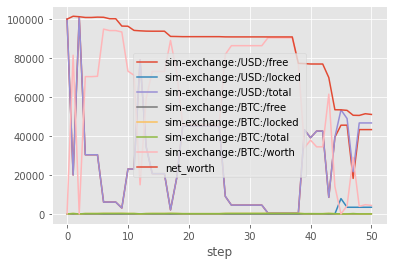

In [24]:
portfolio.performance.plot()

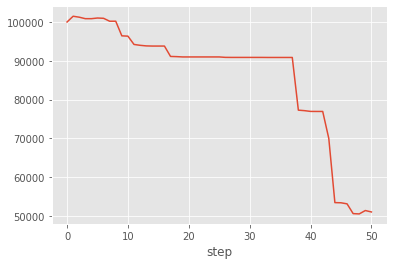

In [25]:
portfolio.performance.net_worth.plot()